## Interpolate and fill SeaWIFS data

Adapted from: https://github.com/adcroft/interp_and_fill/blob/master/Interpolate%20and%20fill%20SeaWIFS.ipynb

In [1]:
import numpy 
import netCDF4
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
%matplotlib inline

### Read MOM6 grid and mask

In [2]:
def MOM6grid(supergrid):
  '''
  Reads supergrid and returns an object with grid metrics
  '''
  # MOM6 supergrid file
  nc_sgrd = netCDF4.Dataset(supergrid)
  x = nc_sgrd.variables['x'][:]
  y = nc_sgrd.variables['y'][:]
  dx = nc_sgrd.variables['dx'][:]
  dy = nc_sgrd.variables['dy'][:]
  area = nc_sgrd.variables['area'][:]
  angle_dx = nc_sgrd.variables['angle_dx'][:]
  nc_sgrd.close()
  #################### Model grid ####################
  # T point locations
  tlon = x[1::2,1::2]
  tlat = y[1::2,1::2]
  # U point locations
  ulon = x[1::2,::2]
  ulat = y[1::2,::2]
  # V point locations
  vlon = x[::2,1::2]
  vlat = y[::2,1::2]
  # Corner point locations
  qlon = x[::2,::2]
  qlat = y[::2,::2]
  # T cell area (sum of four supergrid cells)
  tarea = area[::2,::2] + area[1::2,1::2] + area[::2,1::2] + area[::2,1::2]
  # t-point angle
  angle = angle_dx[1::2,1::2]
  # x-distance between u-points, centered at t
  dxt = dx[1::2,::2] + dx[1::2,1::2]
  # y-distance between v-points, centered at t
  dyt = dy[::2,1::2] + dy[1::2,1::2]
  # x-distance between  q-points, centered at v
  dxCv = dx[2::2,::2] + dx[2::2,1::2]
  # y-distance between  q-points, centered at u
  dyCu = dy[::2,2::2] + dy[1::2,2::2]
  # grid aspect ratio
  ar = dyt / dxt
  # grid effective grid spacing
  # A = 4*pi*r^2 , area of sphere of radius r
  # dA = (r*cos(theta)*dlambda)*(r*dtheta), differential area on sphere
  #    = r^2*domega
  # domega = dA/r^2, differential solid angle  (steradians, sr)
  # 1 sr = (180./pi)^2 square degrees
  costheta = numpy.cos(tlat*numpy.pi/180.)
  rearth = 637122000 # Earth radius in centimeter
  domega = tarea / rearth**2
  egs  = numpy.sqrt(domega * (180./numpy.pi)**2)

  # create an empty class object
  class MOM6_grd:
    pass

  # fill grid object
  MOM6_grd.tlon = tlon
  MOM6_grd.tlat = tlat
  MOM6_grd.ulon = ulon
  MOM6_grd.ulat = ulat
  MOM6_grd.vlon = vlon
  MOM6_grd.vlat = vlat
  MOM6_grd.qlon = qlon
  MOM6_grd.qlat = qlat
  MOM6_grd.dxt = dxt
  MOM6_grd.dyt = dyt
  MOM6_grd.dxCv = dxCv
  MOM6_grd.dyCu = dyCu
  MOM6_grd.angle = angle
  MOM6_grd.tarea = tarea
  MOM6_grd.L = tarea.shape[1]
  MOM6_grd.M = tarea.shape[0]
  print('MOM6 grid was successfully loaded... \n')
  return MOM6_grd

In [3]:
sg_path = '/glade/p/cesmdata/cseg/inputdata/ocn/mom/tx0.66v1/'
grd = MOM6grid('../supergrid/ORCA_gridgen/ocean_hgrid_trimmed.nc')
ocn_qlon = grd.qlon
ocn_qlat = grd.qlat

MOM6 grid was successfully loaded... 



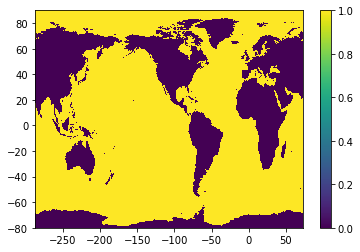

In [4]:
ocn_mask = netCDF4.Dataset('../topography/topo.tx1_4v1.SRTM15_V2.4.SmL1.0_C1.0.nc').variables['mask'][:,:]
ocn_nj, ocn_ni = ocn_mask.shape
plt.pcolormesh(ocn_qlon, ocn_qlat, ocn_mask); plt.colorbar();

### Read SeaWIFS data

In [5]:
src_nc = netCDF4.Dataset('ncfiles/SeaWIFS.L3m_MC_CHL_chlor_a_0.25deg.nc')
src_data = src_nc.variables['chlor_a']
src_nj, src_ni = src_data.shape[-2], src_data.shape[-1]
print('src shape = %i x %i'%(src_nj,src_ni))
src_lon = src_nc.variables[src_data.dimensions[-1]]
src_lat = src_nc.variables[src_data.dimensions[-2]]
src_lat = ((numpy.arange(src_nj)+0.5)/src_nj - 0.5)*180. # Recompute as doubles
src_x0 = int( ( src_lon[0] + src_lon[-1] )/2 + 0.5) - 180.
src_lon = ((numpy.arange(src_ni)+0.5)/src_ni)*360.+src_x0 # Recompute as doubles
src_qlat = ((numpy.arange(src_nj+1))/src_nj - 0.5)*180. # For plotting
src_qlon = ((numpy.arange(src_ni+1))/src_ni)*360.+src_x0 # For plotting

src shape = 720 x 1440


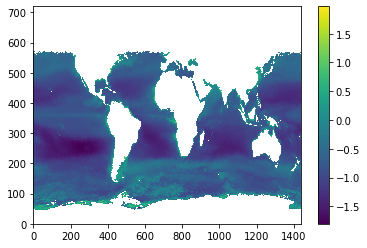

In [6]:
plt.pcolormesh(numpy.ma.log10(src_data[0,::-1,:])); plt.colorbar();

In [7]:
def super_sample_grid(ocn_qlat, ocn_qlon, ocn_mask, src_nj, src_ni):
    nj, ni = ocn_mask.shape
    fac = 1
    while fac*nj<src_nj and fac*ni<src_ni:
        fac += 1
    lon = numpy.zeros( (nj,fac,ni,fac) )
    lat = numpy.zeros( (nj,fac,ni,fac) )
    mask = numpy.zeros( (nj,fac,ni,fac) )
    for j in range(fac):
        ya = ( 2*j+1 ) / ( 2*fac )
        yb = 1. - ya
        for i in range(fac):
            xa = ( 2*i+1 ) / ( 2*fac )
            xb = 1. - xa
            lon[:,j,:,i] = (  yb * ( xb * ocn_qlon[:-1,:-1] + xa * ocn_qlon[:-1,1:] )
                            + ya * ( xb * ocn_qlon[1:,:-1] + xa * ocn_qlon[1:,1:] ) )
            lat[:,j,:,i] = (  yb * ( xb * ocn_qlat[:-1,:-1] + xa * ocn_qlat[:-1,1:] )
                            + ya * ( xb * ocn_qlat[1:,:-1] + xa * ocn_qlat[1:,1:] ) )
    return lat, lon
spr_lat, spr_lon = super_sample_grid(ocn_qlat, ocn_qlon, ocn_mask, src_nj, src_ni)

In [8]:
def latlon2ji(src_lat, src_lon, lat, lon):
    nj, ni = len(src_lat), len(src_lon)
    src_x0 = int( ( src_lon[0] + src_lon[-1] )/2 + 0.5) - 180.
    j = numpy.maximum(0, numpy.floor( ( ( lat + 90. ) / 180. ) * nj - 0.5 ).astype(int))
    i = numpy.mod( numpy.floor( ( ( lon - src_x0 ) / 360. ) * ni - 0.5 ), ni ).astype(int)
    jp1 = numpy.minimum(nj-1, j+1)
    ip1 = numpy.mod(i+1, ni)
    return j,i,jp1,ip1
y, x = src_lat[0], src_lon[0]
latlon2ji(src_lat, src_lon, y, x)

(0, 0, 1, 1)

In [9]:
def super_interp(src_lat, src_lon, data, spr_lat, spr_lon):
    nj, ni = data.shape
    dy, dx = 180./nj, 360./ni
    j0, i0, j1, i1 = latlon2ji(src_lat, src_lon, spr_lat, spr_lon)
    def ydist(lat0, lat1):
        return numpy.abs( lat1-lat0 )
    def xdist(lon0, lon1):
        return numpy.abs( numpy.mod((lon1-lon0)+180, 360) - 180 )
    w_e = xdist( src_lon[i0], spr_lon) / dx
    w_w = 1. - w_e
    w_n = ydist( src_lat[j0], spr_lat) / dy
    w_s = 1. - w_n
    return ( w_s*w_w * data[j0,i0] + w_n*w_e * data[j1,i1] ) + ( w_n*w_w * data[j1,i0] + w_s*w_e * data[j0,i1] )

In [10]:
def fill_missing_data(idata, mask, verbose=True, maxiter=0, debug=False, stabilizer=1.e-14):
    """
    Returns data with masked values objectively interpolated except where mask==0.
    
    Arguments:
    data - numpy.ma.array with mask==True where there is missing data or land.
    mask - numpy.array of 0 or 1, 0 for land, 1 for ocean.
    
    Returns a numpy.ma.array.
    """
    nj,ni = idata.shape
    fdata = idata.filled(0.) # Working with an ndarray is faster than working with a masked array
    if debug:
        plt.figure(); plt.pcolormesh(mask); plt.title('mask'); plt.colorbar();
        #plt.figure(); plt.pcolormesh(idata.mask); plt.title('idata.mask'); plt.colorbar();
        plt.figure(); plt.pcolormesh(idata); plt.title('idata'); plt.colorbar();
        plt.figure(); plt.pcolormesh(idata.filled(3.)); plt.title('idata.filled'); plt.colorbar();
        plt.figure(); plt.pcolormesh(idata.filled(3.)); plt.title('fdata'); plt.colorbar();
    missing_j, missing_i = numpy.where( idata.mask & (mask>0) )
    n_missing = missing_i.size
    if verbose:
        print('Data shape: %i x %i = %i with %i missing values'%(nj, ni, nj*ni, numpy.count_nonzero(idata.mask)))
        print('Mask shape: %i x %i = %i with %i land cells'%(mask.shape[0], mask.shape[1],
                                                                 numpy.prod(mask.shape), numpy.count_nonzero(1-mask)))
        print('Data has %i missing values in ocean'%(n_missing))
        print('Data range: %g .. %g '%(idata.min(),idata.max()))
    # ind contains column of matrix/row of vector corresponding to point [j,i]
    ind = numpy.zeros( fdata.shape, dtype=int ) - int(1e6)
    ind[missing_j,missing_i] = numpy.arange( n_missing )
    if verbose: print('Building matrix')
    A = scipy.sparse.lil_matrix( (n_missing, n_missing) )
    b = numpy.zeros( (n_missing) )
    ld = numpy.zeros( (n_missing) )
    A[range(n_missing),range(n_missing)] = 0.
    if verbose: print('Looping over cells')
    for n in range(n_missing):
        j,i = missing_j[n],missing_i[n]
        im1 = ( i + ni - 1 ) % ni
        ip1 = ( i + 1 ) % ni
        jm1 = max( j-1, 0)
        jp1 = min( j+1, nj-1)
        if j>0 and mask[jm1,i]>0:
            ld[n] -= 1.
            ij = ind[jm1,i]
            if ij>=0:
                A[n,ij] = 1.
            else:
                b[n] -= fdata[jm1,i]
        if mask[j,im1]>0:
            ld[n] -= 1.
            ij = ind[j,im1]
            if ij>=0:
                A[n,ij] = 1.
            else:
                b[n] -= fdata[j,im1]
        if mask[j,ip1]>0:
            ld[n] -= 1.
            ij = ind[j,ip1]
            if ij>=0:
                A[n,ij] = 1.
            else:
                b[n] -= fdata[j,ip1]
        if j<nj-1 and mask[jp1,i]>0:
            ld[n] -= 1.
            ij = ind[jp1,i]
            if ij>=0:
                A[n,ij] = 1.
            else:
                b[n] -= fdata[jp1,i]
        if j==nj-1 and mask[j,ni-1-i]>0: # Tri-polar fold
            ld[n] -= 1.
            ij = ind[j,ni-1-i]
            if ij>=0:
                A[n,ij] = 1.
            else:
                b[n] -= fdata[j,ni-1-i]
    if debug:
        tmp = numpy.zeros((nj,ni)); tmp[ missing_j, missing_i ] = b
        plt.figure(); plt.pcolormesh(tmp); plt.title('b (initial)'); plt.colorbar();
    # Set leading diagonal
    b[ld>=0] = 0.
    A[range(n_missing),range(n_missing)] = ld - stabilizer
    if debug:
        tmp = numpy.zeros((nj,ni)); tmp[ missing_j, missing_i ] = b
        plt.figure(); plt.pcolormesh(tmp); plt.title('b (final)'); plt.colorbar();
        tmp = numpy.ones((nj,ni)); tmp[ missing_j, missing_i ] = A.diagonal()
        plt.figure(); plt.pcolormesh(tmp); plt.title('A[i,i]'); plt.colorbar();
    if verbose: print('Matrix constructed')
    A = scipy.sparse.csr_matrix(A)
    if verbose: print('Matrix converted')
    new_data = numpy.ma.array( fdata, mask=(mask==0))
    if maxiter is None:
        x,info = scipy.sparse.linalg.bicg(A, b)
    elif maxiter==0:
        x = scipy.sparse.linalg.spsolve(A, b)
    else:
        x,info = scipy.sparse.linalg.bicg(A, b, maxiter=maxiter)
    if verbose: print('Matrix inverted')
    new_data[missing_j,missing_i] = x
    return new_data

### Read Chla dataset for tx1_4v1

In [11]:
chla_tx1_4 = netCDF4.Dataset('seawifs-clim-1997-2010-tx1_4v1.nc', 'r+')

In [12]:
chlor_a = chla_tx1_4.variables['CHL_A'][:]

### Main loop

In [13]:
for t in range(src_data.shape[0]):
#for t in range(1):
    q_int = super_interp(src_lat, src_lon, src_data[t,::-1,:], spr_lat, spr_lon)
    q_int = q_int.swapaxes(1,2).reshape((ocn_nj,ocn_ni,q_int.shape[3]*q_int.shape[-1])).mean(axis=-1)
    q = q_int * ocn_mask
    chlor_a[t,:] = fill_missing_data(q, ocn_mask)

Data shape: 1080 x 1440 = 1555200 with 803218 missing values
Mask shape: 1080 x 1440 = 1555200 with 649598 land cells
Data has 155224 missing values in ocean
Data range: 0 .. 66.1113 
Building matrix
Looping over cells
Matrix constructed
Matrix converted
Matrix inverted
Data shape: 1080 x 1440 = 1555200 with 768968 missing values
Mask shape: 1080 x 1440 = 1555200 with 649598 land cells
Data has 121156 missing values in ocean
Data range: 0 .. 52.6533 
Building matrix
Looping over cells
Matrix constructed
Matrix converted
Matrix inverted
Data shape: 1080 x 1440 = 1555200 with 768946 missing values
Mask shape: 1080 x 1440 = 1555200 with 649598 land cells
Data has 121117 missing values in ocean
Data range: 0 .. 29.4216 
Building matrix
Looping over cells
Matrix constructed
Matrix converted
Matrix inverted
Data shape: 1080 x 1440 = 1555200 with 850443 missing values
Mask shape: 1080 x 1440 = 1555200 with 649598 land cells
Data has 202503 missing values in ocean
Data range: 0 .. 34.7537 
Bui

### Compare result against original data

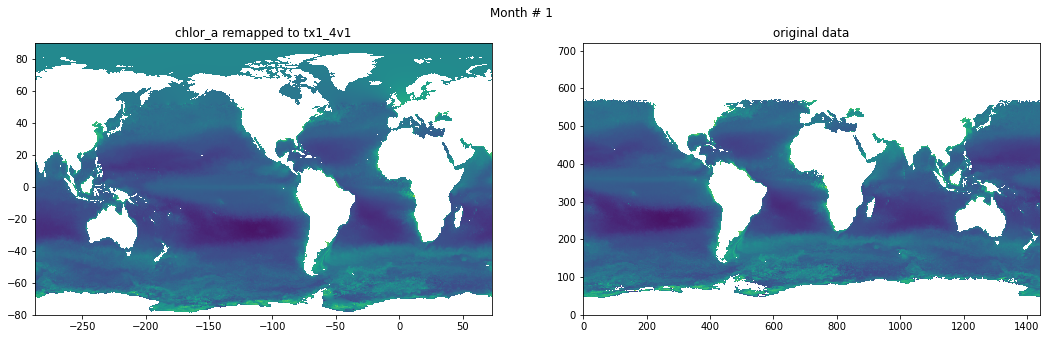

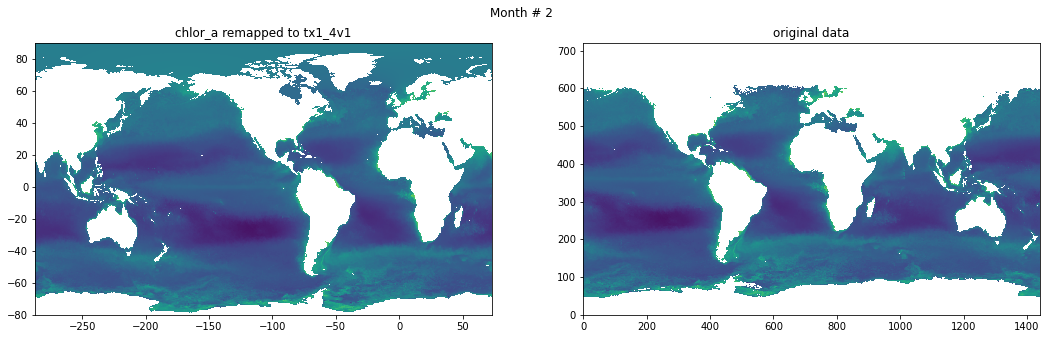

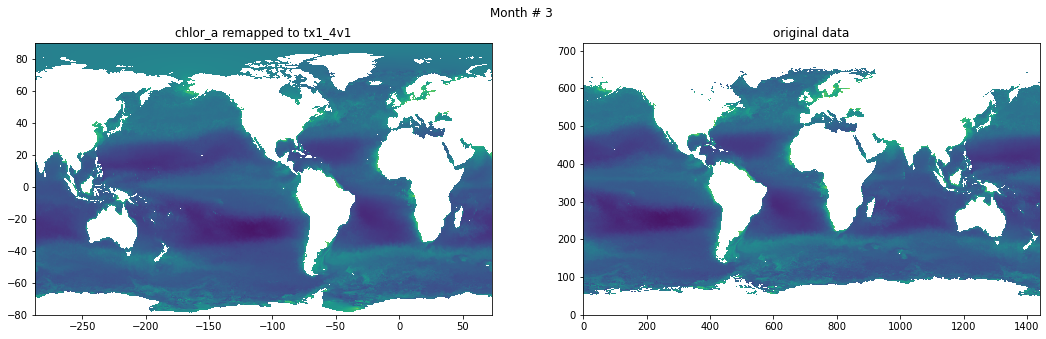

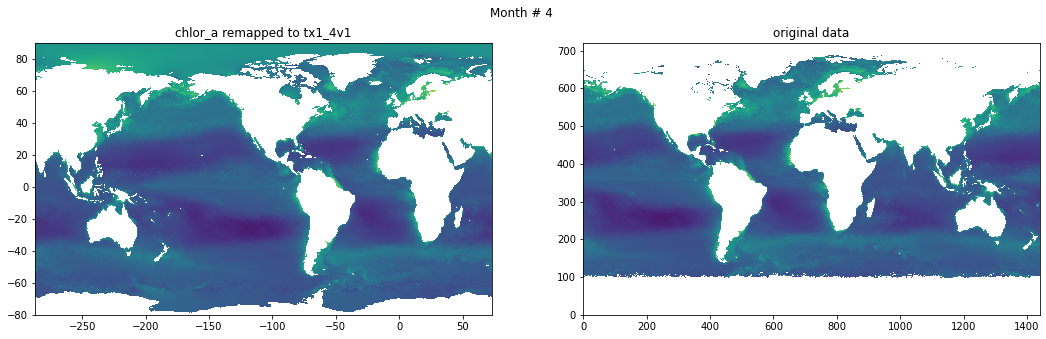

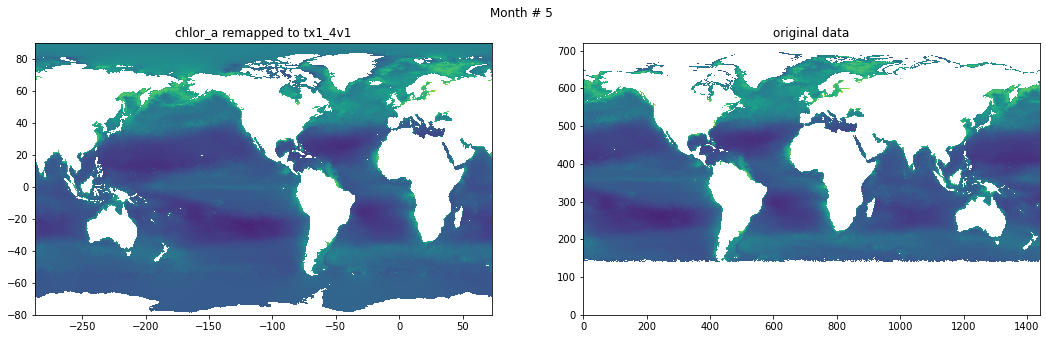

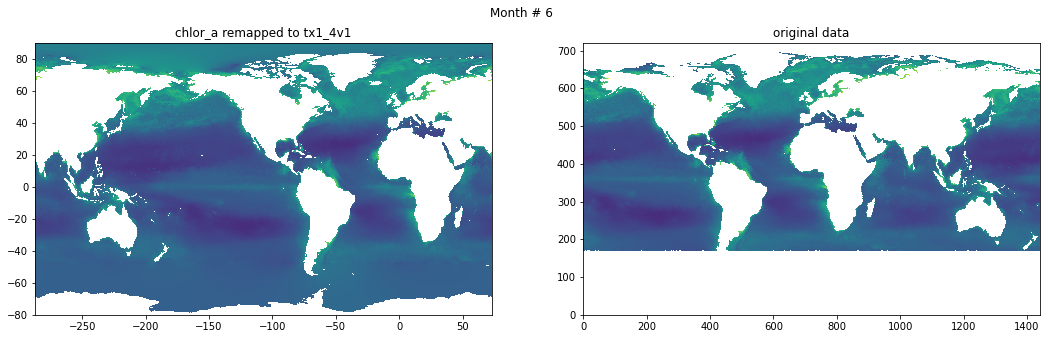

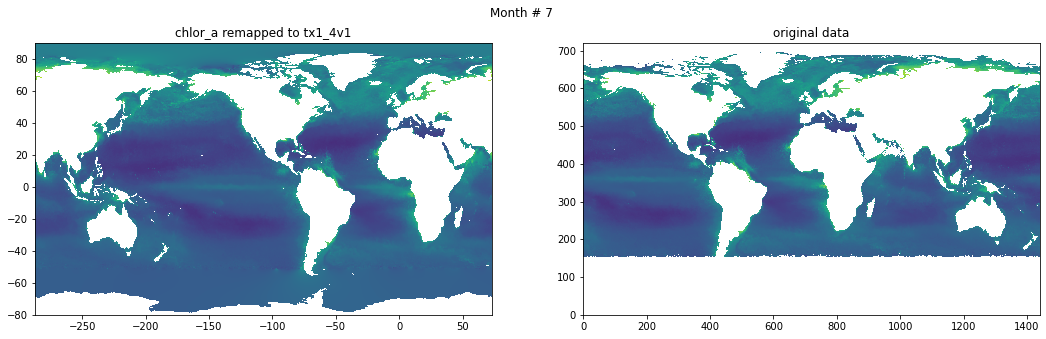

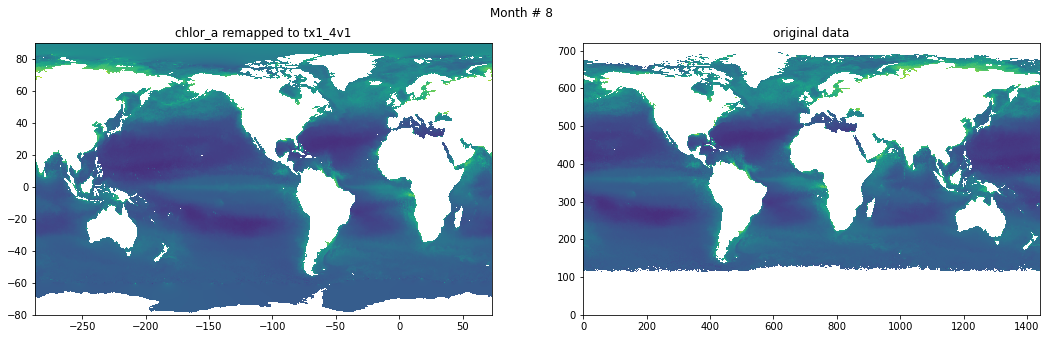

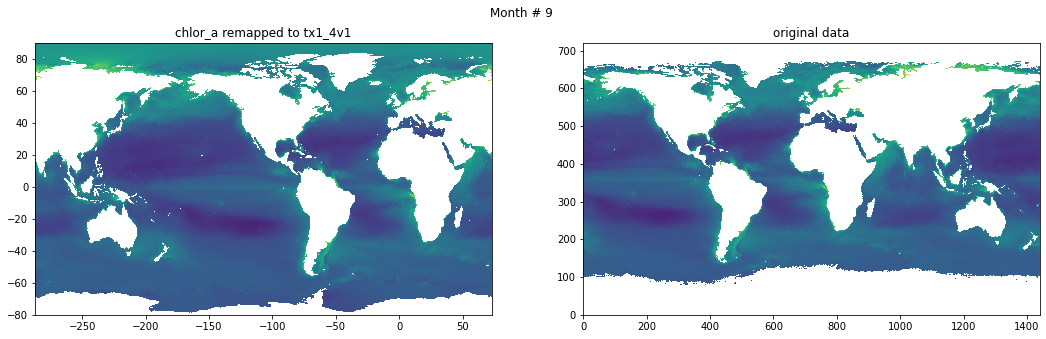

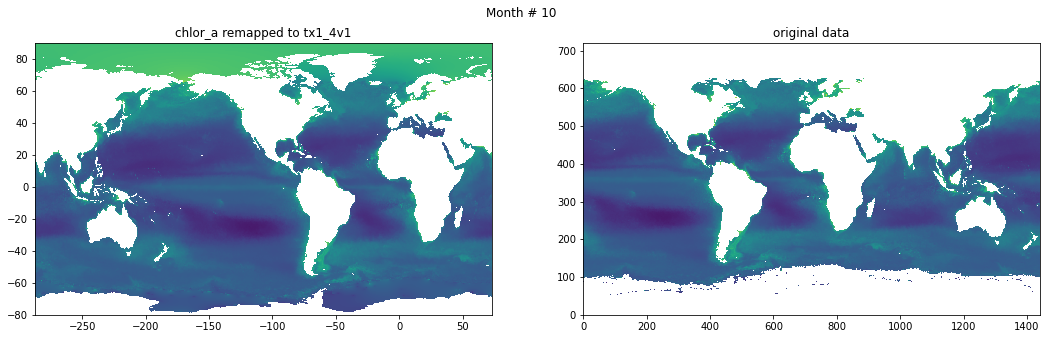

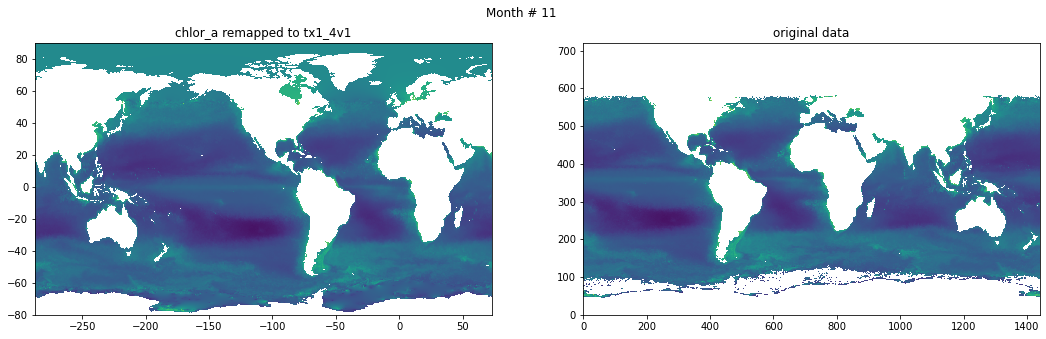

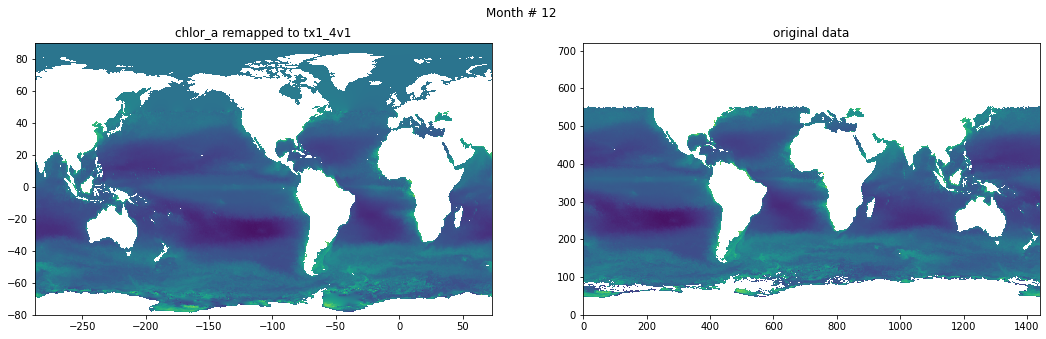

In [14]:
for t in range(src_data.shape[0]):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,5.))
  plt.suptitle('Month # {}'.format(t+1))
  ax[0].pcolormesh(grd.qlon, grd.qlat,numpy.ma.log10(chlor_a[t,:]),vmin=-2,vmax=2)
  ax[0].set_title('chlor_a remapped to tx1_4v1')
    
  ax[1].pcolormesh(numpy.ma.log10(src_data[t,::-1,:]),vmin=-2,vmax=2)
  ax[1].set_title('original data')

#### Save data

In [15]:
from datetime import datetime
# Global attrs
chla_tx1_4.title = 'Chlorophyll Concentration, OCI Algorithm, interpolated and objectivelly filled to tx1_4v1'
chla_tx1_4.repository = 'https://github.com/NCAR/tx1_4/chlorophyll/'
chla_tx1_4.authors = 'Gustavo Marques (gmarques@ucar.edu) and Frank Bryan (bryan@ucar.edu )'
chla_tx1_4.date = datetime.now().isoformat()

In [16]:
jm, im = numpy.shape(grd.tlon)

In [ ]:
chla_tx1_4.variables['CHL_A'][:,:,:] = chlor_a[:,:,:]
chla_tx1_4.variables['LON'][:] = grd.tlon[int(jm/2),:]
chla_tx1_4.variables['LAT'][:] = grd.tlat[:,int(im/2)]

In [18]:
chla_tx1_4.sync()
chla_tx1_4.close()